In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import library
import sindy

import neuromancer.psl as psl
from neuromancer.system import Node, System
from neuromancer.modules import blocks
from neuromancer.modules.activations import activations
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.dynamics import ode, integrators
from neuromancer.plot import pltCL, pltPhase
torch.manual_seed(0)


In [2]:
# ground truth system model
gt_model = psl.nonautonomous.TwoTank(seed=9)
# sampling rate
ts = gt_model.params[1]['ts']
# problem dimensions
nx = gt_model.nx    # number of states
nu = gt_model.nu    # number of control inputs
nref = nx           # number of references
# constraints bounds
umin = 0.
umax = 1.
xmin = 0.
xmax = 1.
sys = gt_model


# white-box ODE model with no-plant model mismatch
two_tank = ode.TwoTankParam()                   # ODE system equations implemented in PyTorch
two_tank.c1 = nn.Parameter(torch.tensor(gt_model.c1), requires_grad=False)
two_tank.c2 = nn.Parameter(torch.tensor(gt_model.c2), requires_grad=False)
# integrate continuous time ODE
integrator = integrators.RK4(two_tank, h=torch.tensor(ts))   # using 4th order runge kutta integrator
# symbolic system model
integrator_node = Node(integrator, ['xn', 'u'], ['xn'], name='model')


In [3]:

def get_policy_data(nsteps, n_samples):
    #  sampled references for training the policy
    list_refs = [torch.rand(1, 1)*torch.ones(nsteps+1, nref) for k in range(n_samples)]
    ref = torch.cat(list_refs)
    batched_ref = ref.reshape([n_samples, nsteps+1, nref])
    # Training dataset
    train_data = DictDataset({'xn': torch.rand(n_samples, 1, nx),   # sampled initial conditions of states
                              'r': batched_ref}, name='train')

    # sampled references for development set
    list_refs = [torch.rand(1, 1)*torch.ones(nsteps+1, nref) for k in range(n_samples)]
    ref = torch.cat(list_refs)
    batched_ref = ref.reshape([n_samples, nsteps+1, nref])
    # Development dataset
    dev_data = DictDataset({'xn': torch.rand(n_samples, 1, nx),    # sampled initial conditions of states
                            'r': batched_ref}, name='dev')

    # torch dataloaders
    batch_size = 200
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                               collate_fn=train_data.collate_fn,
                                               shuffle=False)
    dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=batch_size,
                                             collate_fn=dev_data.collate_fn,
                                             shuffle=False)
    return train_loader, dev_loader

nsteps = 50  # prediction horizon
n_samples = 3000    # number of sampled scenarios

train_loader, dev_loader = get_policy_data(nsteps, n_samples)


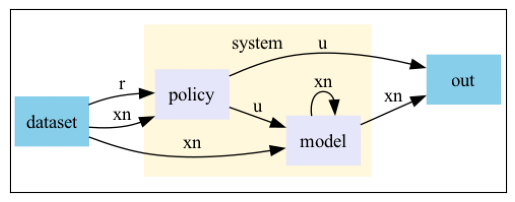

In [4]:

# neural net control policy with hard control action bounds
net = blocks.MLP_bounds(insize=nx + nref, outsize=nu, hsizes=[32, 32],
                    nonlin=activations['gelu'], min=umin, max=umax)
policy = Node(net, ['xn', 'r'], ['u'], name='policy')

# closed-loop system model
cl_system = System([policy, integrator_node], nsteps=nsteps)
cl_system.show()


In [5]:
# variables
x = variable('xn')
ref = variable('r')
# objectives
regulation_loss = 5. * ((x == ref) ^ 2)  # target posistion
# constraints
state_lower_bound_penalty = 10.*(x > xmin)
state_upper_bound_penalty = 10.*(x < xmax)
terminal_lower_bound_penalty = 10.*(x[:, [-1], :] > ref-0.01)
terminal_upper_bound_penalty = 10.*(x[:, [-1], :] < ref+0.01)
# objectives and constraints names for nicer plot
regulation_loss.name = 'state_loss'
state_lower_bound_penalty.name = 'x_min'
state_upper_bound_penalty.name = 'x_max'
terminal_lower_bound_penalty.name = 'y_N_min'
terminal_upper_bound_penalty.name = 'y_N_max'
# list of constraints and objectives
objectives = [regulation_loss]
constraints = [
    state_lower_bound_penalty,
    state_upper_bound_penalty,
    terminal_lower_bound_penalty,
    terminal_upper_bound_penalty,
]


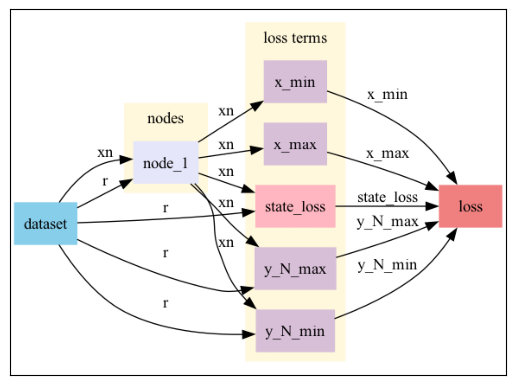

In [6]:

# data (x_k, r_k) -> parameters (xi_k) -> policy (u_k) -> dynamics (x_k+1)
components = [cl_system]
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)
# construct constrained optimization problem
problem = Problem(components, loss)
# plot computational graph
problem.show()

In [7]:
optimizer = torch.optim.AdamW(policy.parameters(), lr=0.002)
#  Neuromancer trainer
trainer = Trainer(
    problem,
    train_loader, dev_loader,
    optimizer=optimizer,
    epochs=100,
    train_metric='train_loss',
    eval_metric='dev_loss',
    warmup=50,
)
# Train control policy
best_model = trainer.train()
# load best trained model
trainer.model.load_state_dict(best_model)



epoch: 0  train_loss: 4.736507892608643
epoch: 1  train_loss: 3.8805418014526367
epoch: 2  train_loss: 3.2483129501342773
epoch: 3  train_loss: 2.3616526126861572
epoch: 4  train_loss: 1.329271912574768
epoch: 5  train_loss: 1.0159586668014526
epoch: 6  train_loss: 0.8617544770240784
epoch: 7  train_loss: 0.7372915148735046
epoch: 8  train_loss: 0.6343743205070496
epoch: 9  train_loss: 0.5478888750076294
epoch: 10  train_loss: 0.4831804633140564
epoch: 11  train_loss: 0.43613114953041077
epoch: 12  train_loss: 0.40173691511154175
epoch: 13  train_loss: 0.37549081444740295
epoch: 14  train_loss: 0.35497552156448364
epoch: 15  train_loss: 0.3376488983631134
epoch: 16  train_loss: 0.32289406657218933
epoch: 17  train_loss: 0.3108222186565399
epoch: 18  train_loss: 0.3005513846874237
epoch: 19  train_loss: 0.2922228276729584
epoch: 20  train_loss: 0.2846883535385132
epoch: 21  train_loss: 0.27795499563217163
epoch: 22  train_loss: 0.2724117040634155
epoch: 23  train_loss: 0.267641067504882

<All keys matched successfully>

In [49]:
nsteps = 750
step_length = 150
# generate reference
np_refs = psl.signals.step(nsteps+1, 1, min=xmin, max=xmax, randsteps=5)
R = torch.tensor(np_refs, dtype=torch.float32).reshape(1, nsteps+1, 1)
torch_ref = torch.cat([R, R], dim=-1)
# generate initial data for closed loop simulation
data = {'xn': torch.rand(1, 1, nx, dtype=torch.float32),
        'r': torch_ref}

(<Figure size 2000x1600 with 2 Axes>,
 array([[<Axes: xlabel='Time', ylabel='y'>],
        [<Axes: xlabel='Time', ylabel='u'>]], dtype=object))

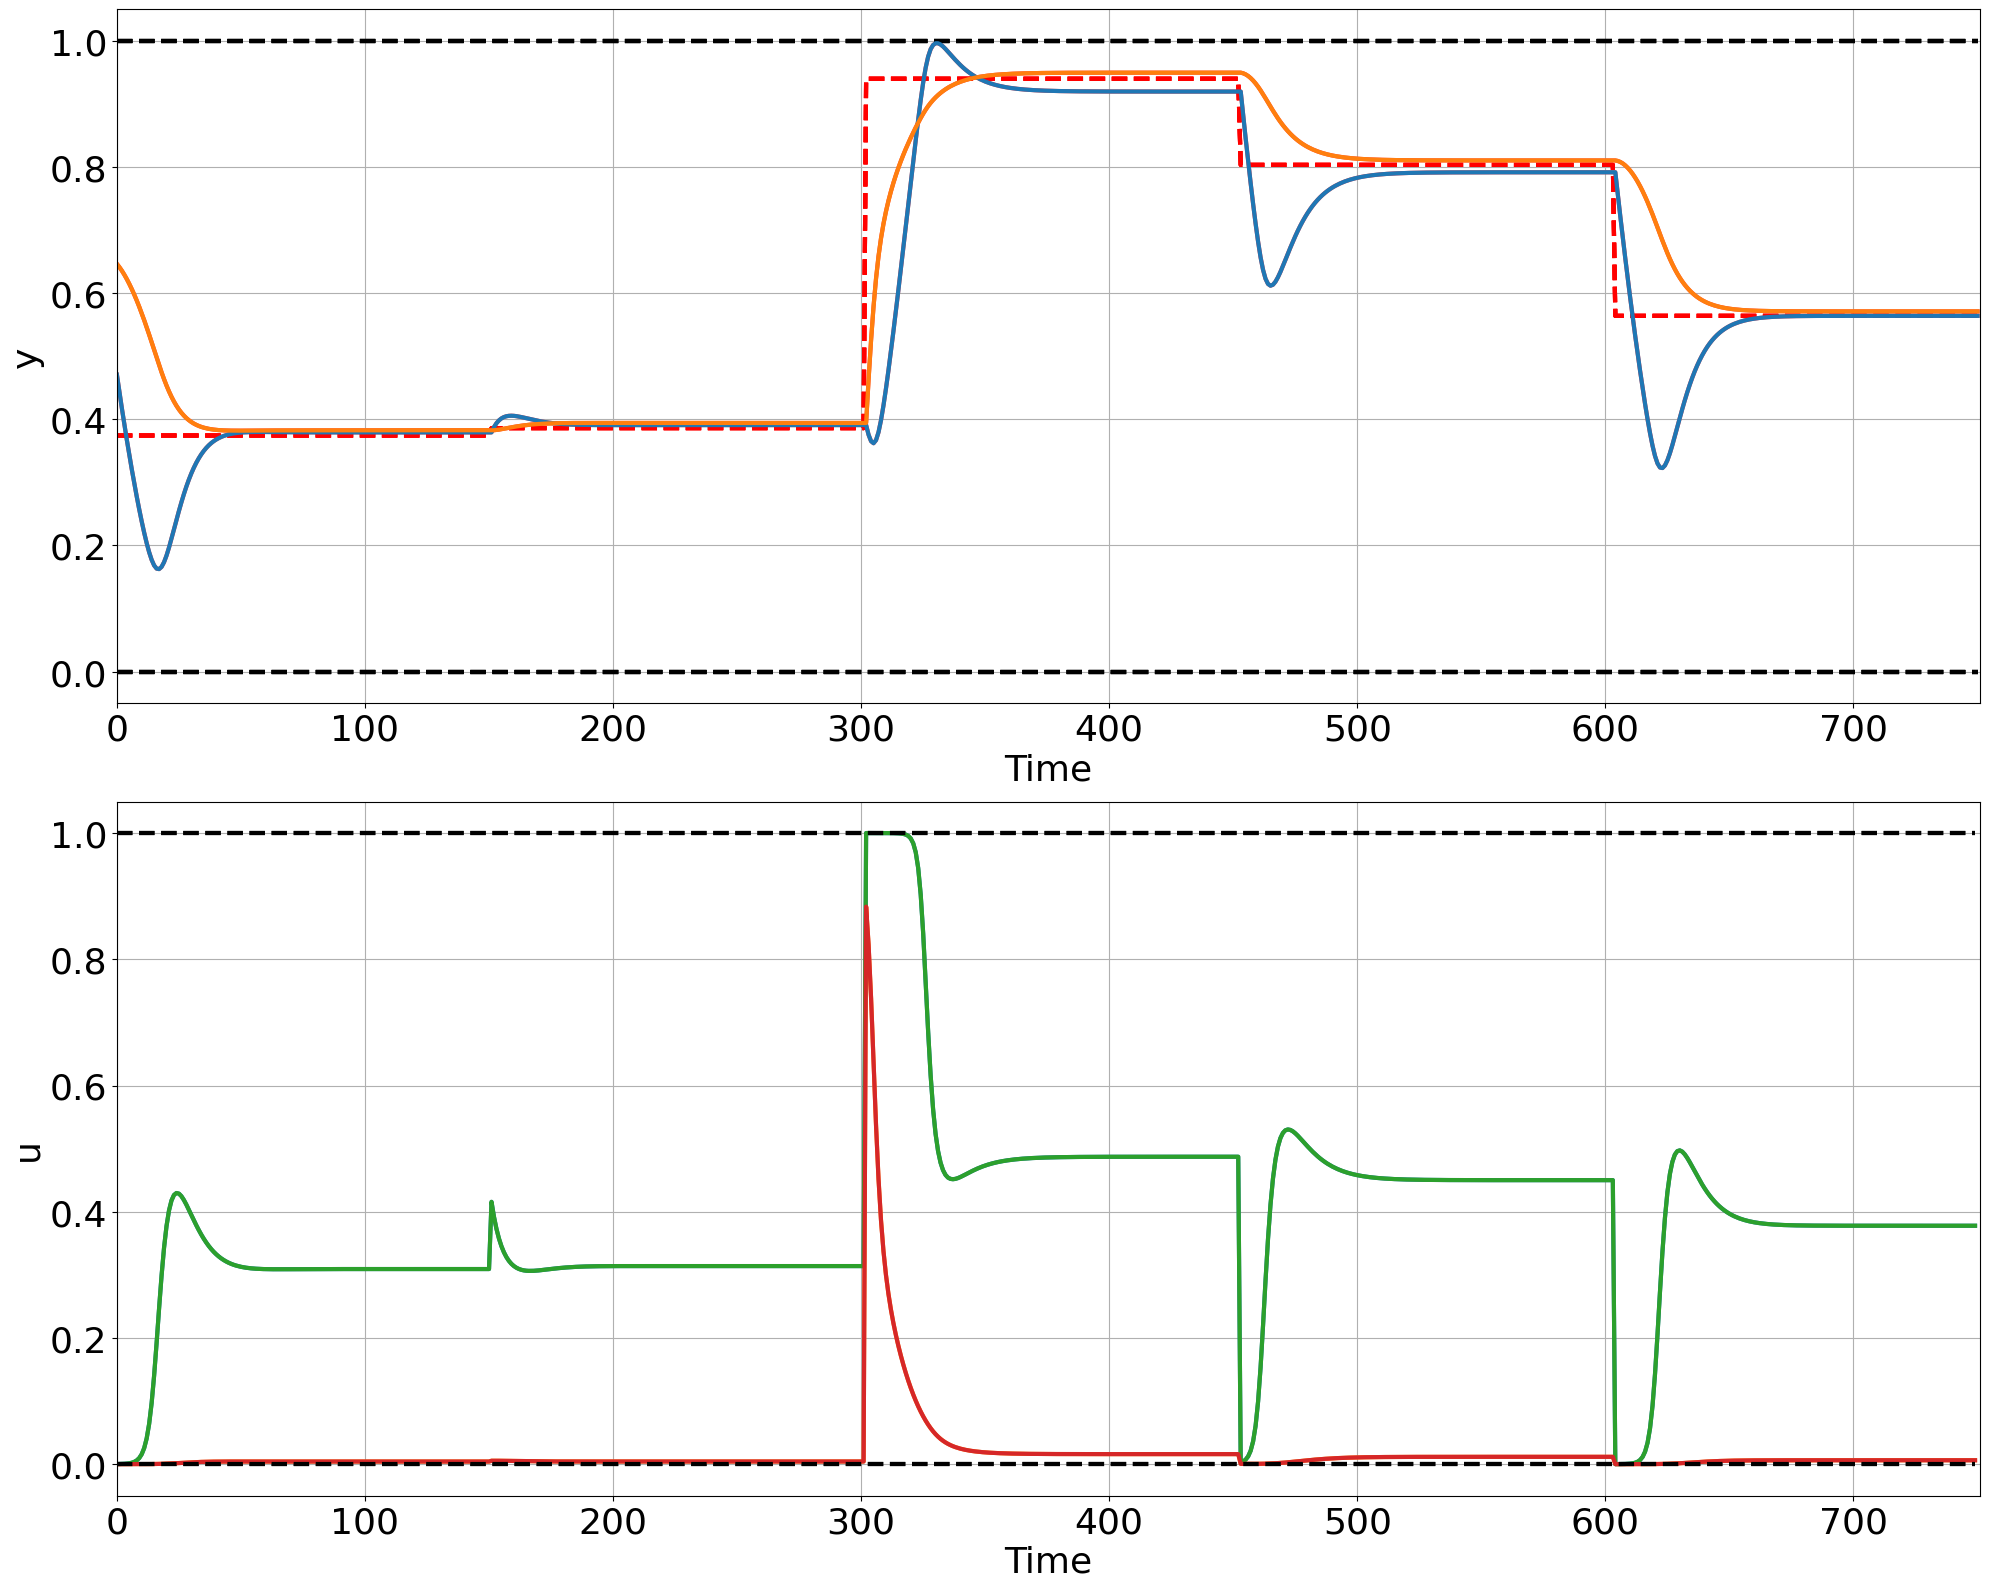

In [53]:
two_tank.c1 = nn.Parameter(torch.tensor(gt_model.c1, requires_grad=False))
two_tank.c2 = nn.Parameter(torch.tensor(gt_model.c2, requires_grad=False))

cl_system.nsteps = nsteps
# perform closed-loop simulation
trajectories = cl_system(data)

# constraints bounds
Umin = umin * np.ones([nsteps, nu])
Umax = umax * np.ones([nsteps, nu])
Xmin = xmin * np.ones([nsteps+1, nx])
Xmax = xmax * np.ones([nsteps+1, nx])
# plot closed loop trajectories
pltCL(Y=trajectories['xn'].detach().reshape(nsteps + 1, nx),
      R=trajectories['r'].detach().reshape(nsteps + 1, nref),
      U=trajectories['u'].detach().reshape(nsteps, nu),
      Umin=Umin, Umax=Umax, Ymin=Xmin, Ymax=Xmax,
      figname='cl.png')

In [98]:
noise_level = 0.4
noise = torch.randn(1) * noise_level
two_tank.c1 = nn.Parameter(torch.tensor(gt_model.c1) + noise, requires_grad=False)
two_tank.c2 = nn.Parameter(torch.tensor(gt_model.c2) + noise, requires_grad=False)

two_tank.c1 = nn.Parameter(torch.tensor(0.05, requires_grad=False))
two_tank.c2 = nn.Parameter(torch.tensor(0.03, requires_grad=False))
print("New c1: ",two_tank.c1)
print("New c2: ",two_tank.c2)

New c1:  Parameter containing:
tensor(0.0500, requires_grad=True)
New c2:  Parameter containing:
tensor(0.0300, requires_grad=True)


(<Figure size 2000x1600 with 2 Axes>,
 array([[<Axes: xlabel='Time', ylabel='y'>],
        [<Axes: xlabel='Time', ylabel='u'>]], dtype=object))

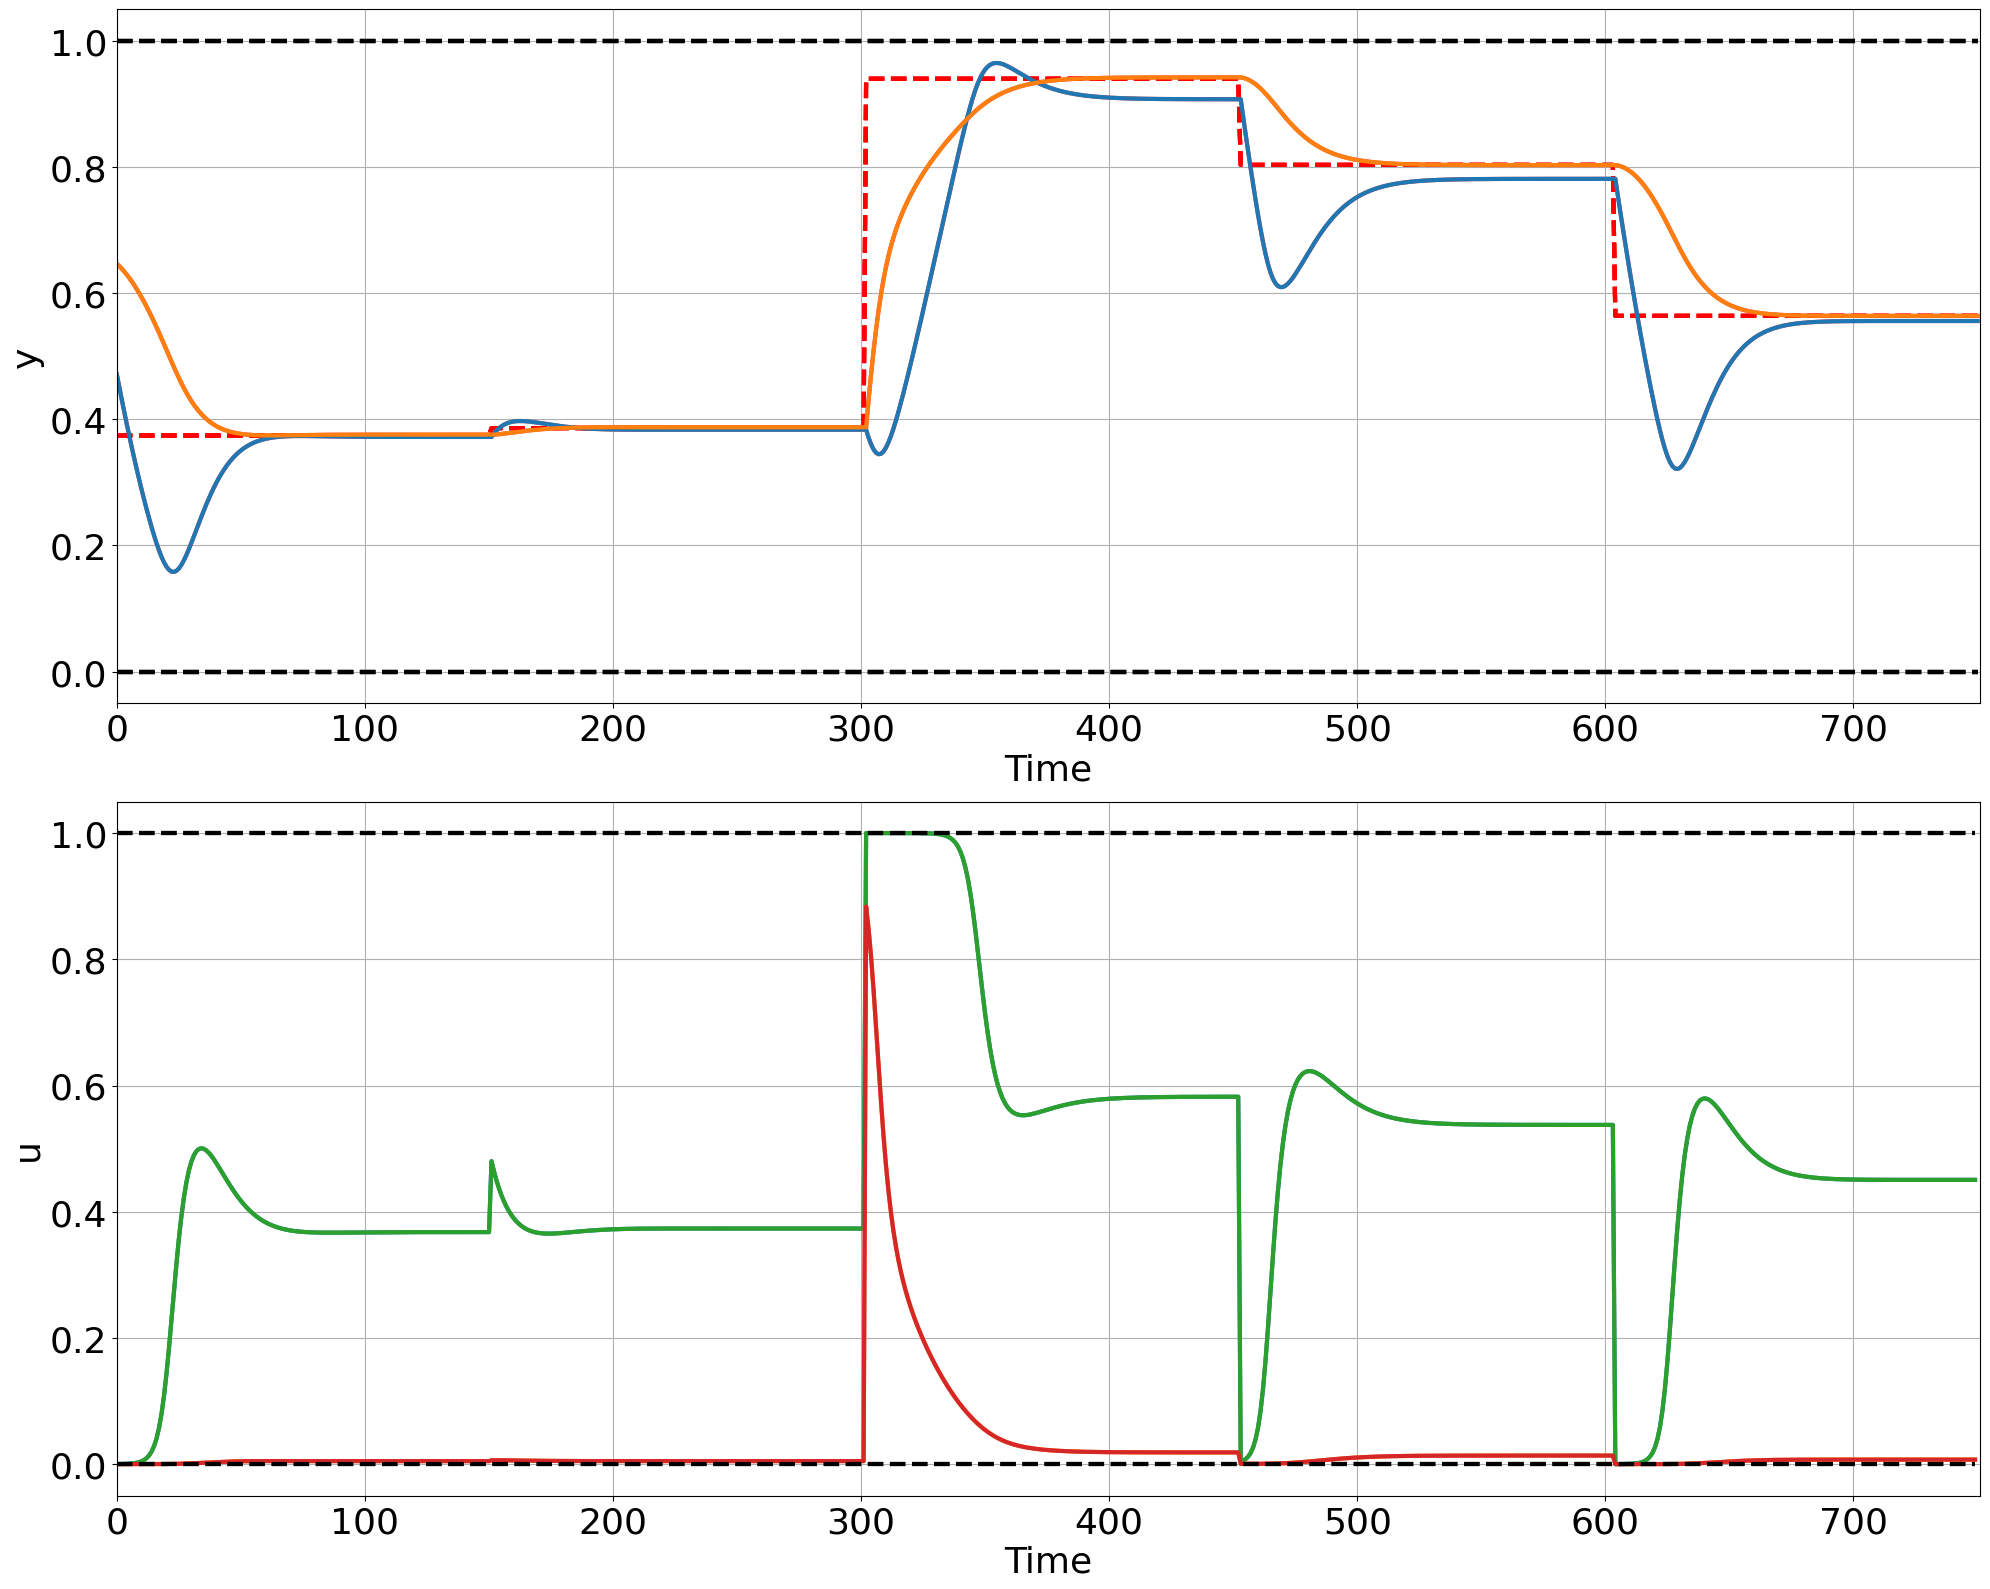

In [99]:
cl_system.nsteps = nsteps
# perform closed-loop simulation
trajectories = cl_system(data)

# constraints bounds
Umin = umin * np.ones([nsteps, nu])
Umax = umax * np.ones([nsteps, nu])
Xmin = xmin * np.ones([nsteps+1, nx])
Xmax = xmax * np.ones([nsteps+1, nx])
# plot closed loop trajectories
pltCL(Y=trajectories['xn'].detach().reshape(nsteps + 1, nx),
      R=trajectories['r'].detach().reshape(nsteps + 1, nref),
      U=trajectories['u'].detach().reshape(nsteps, nu),
      Umin=Umin, Umax=Umax, Ymin=Xmin, Ymax=Xmax,
      figname='cl.png')

In [60]:
print(trajectories["xn"][:,1,:])

tensor([[0.4435, 0.6410]], grad_fn=<SliceBackward0>)


In [84]:

policy.zero_grad()
mse_loss_fn = nn.MSELoss(reduction='mean')  # instantiate the loss function
loss = mse_loss_fn(
    trajectories["xn"][:, 2, :],
    torch.zeros_like(trajectories["xn"][:, 2, :])
)


In [85]:
loss.backward()

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [69]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.002
    maximize: False
    weight_decay: 0.01
)

In [83]:
for param in policy.parameters():
    print(param.grad)

None
None
None
None
None
None
